In [1]:
import requests
import os
import sys
import pandas as pd
import numpy as np


from typing import Optional
import glob
from scipy import stats
# Add the parent directory of this notebook to sys.path
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(notebook_dir)
sys.path.append(parent_dir)

from project_tools import project_utils, project_class

import datetime
import json
from tqdm.notebook import tqdm
import gc
# import ds_utils
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, ndcg_score
from scipy.stats import kendalltau, spearmanr
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import log_loss, accuracy_score
from scipy import stats
%matplotlib inline

from importlib import reload
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.0f' % x)

# Or for more precise control
pd.set_option('display.float_format', '{:.5f}'.format)

# evaluation functions

In [2]:
def evaluate_horse_race_positions(y_true, y_pred_proba, dnf_value=99):
    """
    Evaluate predictions for a single race's finishing positions.
    
    Args:
        y_true: 1D array of true finishing positions
        y_pred_proba: 1D array of predicted probabilities
        dnf_value: Value used to indicate Did Not Finish
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Handle NaN and DNF values in ground truth
    y_true_processed = y_true.copy()
    invalid_mask = np.logical_or(
        np.isnan(y_true),
        y_true == dnf_value
    )
    
    # Get max valid rank (excluding DNF values)
    valid_ranks = y_true[~invalid_mask]
    if len(valid_ranks) > 0:
        max_rank = np.max(valid_ranks)
        # Replace invalid values with max_rank + 1
        y_true_processed[invalid_mask] = max_rank + 1
        
    # Winner match
    y_true_ranksort = np.argsort(y_true_processed)
    y_pred_ranksort = np.argsort(y_pred_proba, axis=0)[::-1]
    
    winner_match = y_true_ranksort[0] == y_pred_ranksort[0]
    
    # Top 3 Set Match - considers [1,3,2] and [2,3,1] as matching
    top3_set_match = set(y_true_ranksort[:3]) == set(y_pred_ranksort[:3])
    
    # Top 3 Exact Match - only considers exact matches like [1,3,2] and [1,3,2]
    top3_exact_match = np.array_equal(y_true_ranksort[:3], y_pred_ranksort[:3])
    
    return {
        'Winner Match': float(winner_match),
        'Top 3 Set Match': float(top3_set_match), 
        'Top 3 Exact Match': float(top3_exact_match)
    }


In [3]:
def evaluate_prediction_sets(eval_dict):
    """
    Evaluate different prediction sets against ground truth for each race and calculate mean metrics
    
    Args:
        eval_dict: Dictionary containing race data with ground truth and different prediction sets
        
    Returns:
        tuple: (eval_result, mean_results_df)
            - eval_result: Dictionary with detailed evaluation metrics for each race
            - mean_results_df: DataFrame comparing mean metrics across prediction types
    """
    # Initialize results dictionary with race_ids as first level keys
    eval_result = {race_id: {} for race_id in eval_dict}

    # Get prediction types from first race data
    first_race_id = next(iter(eval_dict))
    pred_types = [key for key in eval_dict[first_race_id].keys() if key != 'ground_truth']

    # Initialize dictionaries to store mean results
    mean_results = {pred_type: {} for pred_type in pred_types}

    # Loop through each race
    for race_id in eval_dict:
        race_data = eval_dict[race_id]
        ground_truth = race_data['ground_truth']
        
        # Evaluate each prediction type
        for pred_type in pred_types:
            pred_probs = race_data[pred_type]
            
            # Evaluate predictions for this race
            race_eval = evaluate_horse_race_positions(
                ground_truth,
                pred_probs
            )
            
            # Store results for this race under race_id first, then pred_type
            eval_result[race_id][pred_type] = race_eval

    # Calculate mean results for each prediction type
    for pred_type in pred_types:
        # Initialize dict to store means for each metric
        metric_means = {}
        
        # Get metrics from first race to know what metrics exist
        first_race = next(iter(eval_result.values()))
        metrics = first_race[pred_type].keys()
        
        # For each metric, calculate mean across all races
        for metric in metrics:
            total = 0
            num_races = 0
            for race_id in eval_result:
                total += eval_result[race_id][pred_type][metric]
                num_races += 1
            metric_means[metric] = total / num_races
            
        mean_results[pred_type] = metric_means
    
    # Convert mean results to DataFrame for easy comparison
    mean_results_df = pd.DataFrame(mean_results)
    
    return eval_result, mean_results_df

# # Run evaluation
# eval_result, mean_results_df = evaluate_prediction_sets(eval_dict)

# # Display mean results comparison
# print("\nMean Evaluation Metrics Comparison:")
# print(mean_results_df)


# lightgbm training function

In [55]:
def train_lightgbm_model(train_df, val_df, label_col, cat_features=None, 
                         params=None, class_weight=None, num_classes=3, 
                         n_estimators=300, verbose=True):
    """
    Train a LightGBM model for binary classification using LGBMClassifier
    
    Args:
        train_df: Training dataframe containing features and label
        val_df: Validation dataframe containing features and label  
        label_col: Name of label column (should contain binary values 0/1)
        cat_features: List of categorical feature names
        params: Dict of LightGBM parameters
        
    Returns:
        Trained model and validation predictions
    """
    # Default parameters if none provided
    if params is None:
        params = {
            'objective': 'multiclass',
            'metric': ['multi_logloss', 'multi_error'],
            'boosting_type': 'gbdt',
            'num_class': num_classes,
            'n_estimators':150,
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,  # Column sampling
            'bagging_fraction': 0.8,  # Row sampling 
            'bagging_freq': 5,
            'verbose': -1,
            'max_depth': -1,
            'min_child_samples': 20,
            'reg_alpha': 0.0,
            'reg_lambda': 0.0,
            'is_unbalance': True  # Handle unbalanced datasets
        }
    features = [col for col in train_df.columns if col != label_col]
    X_train = train_df[features]
    y_train = train_df[label_col]
    
    if val_df is not None:
        X_val = val_df[features]
        # y_val = val_df[label_col]
        

    # Create LightGBM datasets
    train_data = lgb.Dataset(
        X_train, 
        label=y_train,
        categorical_feature=cat_features if cat_features else 'auto',

    )
    val_data = lgb.Dataset(
        X_val,
        categorical_feature=cat_features if cat_features else 'auto',
        reference=train_data
    )
    
    # Train model
    model = lgb.train(
        params,
        train_data,
        num_boost_round=n_estimators,
        valid_sets=None,
        # verbose_eval=100 if val_df is not None else -1
    )
    val_preds = model.predict(X_val)
    return model, val_preds

# load data

In [7]:
horse_race_df = pd.read_parquet('../feature_data/horse_race_df.parquet')
horse_race_df = horse_race_df.sort_values(by=['clean_race_date','race_id'], ascending=True).reset_index(drop=True)
basic_cat_ordinal_df = pd.read_parquet('../feature_data/basic_cat_ordinal_features.parquet')

In [11]:
target1 = 'clean_position'
df_rank = pd.read_parquet('../feature_data/baseline_features/lgbm_rank_baseline_dataset.parquet')
df_rank[target1] = horse_race_df[target1]

# multi-class preparation functions

In [13]:
def transform_racing_positions(df: pd.DataFrame, position_col: str = 'clean_position', 
                               new_col: str = 'label') -> pd.DataFrame:
    """
    Transform horse racing positions into multiclass labels:
    0: is_winner (position == 1)
    1: is_top3 (position in [2, 3])
    2: outside_top3 (position > 3)
    
    Args:
        df: Input dataframe containing race results
        position_col: Name of column containing finishing positions
        new_col: Name of new column to store class labels
        
    Returns:
        DataFrame with new column containing transformed class labels
    """
    # Make a copy to avoid modifying original dataframe
    result_df = df.copy()
    
    # Create position class labels
    result_df[new_col] = np.where(
        result_df[position_col] == 1, 0,     # Winner (class 0)
        np.where(
            result_df[position_col].between(2, 3), 1,  # Top 3 (class 1)
            2  # Outside top 3 (class 2)
        )
    )
    
    # Validate the transformation
    class_counts = result_df[new_col].value_counts().sort_index()
    print("Class distribution:")
    print(f"Class 0 (Winners): {class_counts[0]} ({class_counts[0]/len(df)*100:.1f}%)")
    print(f"Class 1 (Top 3): {class_counts[1]} ({class_counts[1]/len(df)*100:.1f}%)")
    print(f"Class 2 (Outside Top 3): {class_counts[2]} ({class_counts[2]/len(df)*100:.1f}%)")
    
    return result_df


def get_class_weights(df: pd.DataFrame, label_col: str = 'position_class') -> dict:
    """
    Calculate class weights inversely proportional to class frequencies.
    Useful for handling imbalanced racing position data.
    
    Args:
        df: Input dataframe with position classes
        label_col: Name of column containing class labels
        
    Returns:
        Dictionary of class weights {class_label: weight}
    """
    class_counts = df[label_col].value_counts()
    total = len(df)
    
    # Calculate weights inversely proportional to class frequencies
    weights = {
        class_label: total / (len(class_counts) * count)
        for class_label, count in class_counts.items()
    }
    
    print("Class weights:")
    for class_label, weight in sorted(weights.items()):
        print(f"Class {class_label}: {weight:.3f}")
    
    return weights

In [14]:
df_multcls = df_rank.copy()
df_multcls = transform_racing_positions(df_rank)

class_weights = get_class_weights(df_multcls, "label")

Class distribution:
Class 0 (Winners): 2387 (8.1%)
Class 1 (Top 3): 4738 (16.1%)
Class 2 (Outside Top 3): 22395 (75.9%)
Class weights:
Class 0: 4.122
Class 1: 2.077
Class 2: 0.439


In [16]:
train_years = ['2014','2015','2016']
val_years = ['2017']
train_idx = horse_race_df[horse_race_df['year'].isin(train_years)].index
val_idx = horse_race_df[horse_race_df['year'].isin(val_years)].index
print(len(train_idx), len(val_idx))

23232 6288


In [20]:
print(df_multcls.columns)

Index(['horse_number', 'clean_actual_weight', 'clean_declared_horse_weight',
       'clean_win_odds', 'race_distance', 'race_id', 'jockey', 'trainer',
       'race_course', 'race_course_track', 'race_class', 'track_condition',
       'jockey_bin_0', 'jockey_bin_1', 'jockey_bin_2', 'jockey_bin_3',
       'jockey_bin_4', 'jockey_bin_5', 'jockey_bin_6', 'trainer_bin_0',
       'trainer_bin_1', 'trainer_bin_2', 'trainer_bin_3', 'trainer_bin_4',
       'trainer_bin_5', 'trainer_bin_6', 'race_course_bin_0',
       'race_course_track_bin_0', 'race_course_track_bin_1',
       'race_course_track_bin_2', 'race_course_track_bin_3',
       'race_class_bin_0', 'race_class_bin_1', 'race_class_bin_2',
       'race_class_bin_3', 'track_condition_bin_0', 'track_condition_bin_1',
       'track_condition_bin_2', 'track_condition_bin_3', 'jockey_freq',
       'trainer_freq', 'race_course_freq', 'race_course_track_freq',
       'race_class_freq', 'track_condition_freq', 'awght_dwght_ratio',
       'awght_d

In [57]:
num_classes = df_multcls['label'].nunique()

params = {
    'objective': 'multiclass',
    'metric': ['multi_logloss', 'multi_error'],
    'boosting_type': 'gbdt',
    'num_class': num_classes,
    # 'n_estimators':300,
    'num_leaves': 32,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,  # Column sampling
    'bagging_fraction': 0.8,  # Row sampling 
    'bagging_freq': 5,
    'verbose': -1,
}


train_df = df_multcls.loc[train_idx].drop('clean_position', axis=1)
val_df = df_multcls.loc[val_idx].drop('clean_position', axis=1)
target = 'label'

basic_cat_features = basic_cat_ordinal_df.columns.tolist()
use_cats = [c for c in train_df.columns if c in basic_cat_features]
model_multicls, val_preds = train_lightgbm_model(train_df, val_df, 'label', 
                                                 cat_features= use_cats,  params=params,
                                                 num_classes=num_classes, class_weight=None, 
                                                 n_estimators=300, verbose=True)  

In [58]:
val_preds[0:3]

array([[0.06347463, 0.30275252, 0.63377284],
       [0.09060867, 0.36023852, 0.54915281],
       [0.02773474, 0.17061655, 0.80164872]])

In [59]:
y_val = val_df['label']
val_logloss = log_loss(y_val, val_preds)
val_preds_class = np.argmax(val_preds, axis=1)
val_acc = accuracy_score(y_val, val_preds_class)
print(f'Validation MultiClass LogLoss: {val_logloss:.4f}')
print(f'Validation Accuracy: {val_acc:.4f}')

Validation MultiClass LogLoss: 0.6387
Validation Accuracy: 0.7525


# generate race position prediction

In [93]:
def generate_race_positions(val_df, pred_probs, race_id_col='race_id'):
    """
    Generate race positions from multiclass probabilities for each race
    
    Args:
        val_df: Validation dataframe containing race_id
        pred_probs: Array of prediction probabilities [n_samples, n_classes]
        race_id_col: Name of race ID column
        
    Returns:
        Array of predicted positions for each horse
    """
    # Convert predictions to DataFrame for easier manipulation
    pred_df = pd.DataFrame(pred_probs, columns=['win_prob', 'place_prob', 'other_prob'])
    pred_df['race_id'] = val_df[race_id_col].values
    pred_df['orig_index'] = range(len(pred_df))
    
    # Initialize results array
    final_positions = np.zeros(len(pred_df))
    
    # Process each race
    for race_id in pred_df['race_id'].unique():
        # Get predictions for current race
        race_mask = pred_df['race_id'] == race_id
        race_preds = pred_df[race_mask].copy()
        n_horses = len(race_preds)
        
        # Initialize positions for this race
        race_positions = np.zeros(n_horses)
        assigned_indices = set()
        
        # 1. Find winner (highest win probability)
        winner_idx = race_preds['win_prob'].argmax()
        race_positions[winner_idx] = 1
        assigned_indices.add(winner_idx)
        
        # 2. Find places (2nd and 3rd) from place probability
        # Exclude already assigned horses
        unassigned_mask = ~race_preds.index.isin([race_preds.index[winner_idx]])
        place_candidates = race_preds[unassigned_mask]
        
        # Get top 2 from place probability
        if len(place_candidates) >= 2:
            place_indices = place_candidates['place_prob'].nlargest(2).index
            for pos, idx in enumerate(place_indices, start=2):
                race_positions[race_preds.index.get_loc(idx)] = pos
                assigned_indices.add(race_preds.index.get_loc(idx))
        
        # 3. Assign remaining positions based on other_prob
        remaining_indices = set(range(n_horses)) - assigned_indices
        if remaining_indices:
            remaining_mask = ~race_preds.index.isin([race_preds.index[i] for i in assigned_indices])
            remaining = race_preds[remaining_mask]
            
            # Sort remaining horses by other_prob
            remaining_sorted = remaining.sort_values('other_prob', ascending=False)
            
            # Assign positions 4 onwards
            for pos, idx in enumerate(remaining_sorted.index, start=4):
                race_positions[race_preds.index.get_loc(idx)] = pos
        
        # Store positions in final array using original indices
        final_positions[race_preds['orig_index']] = race_positions
    
    return final_positions.astype(int)

In [106]:
val_horse_race_df = horse_race_df.loc[val_idx].reset_index(drop=True)
val_horse_race_df['lgbm_multicls_preds'] = 20 - generate_race_positions(val_horse_race_df, 
                                                                   val_preds, 'race_id')

# val_horse_race_df['lgbm_multicls_preds'] = 

In [120]:
use_race_id = val_horse_race_df['race_id'].sample(1).values[0]
use_cols = ['race_id', 'horse_number', 'clean_position','lgbm_multicls_preds']
race_df = val_horse_race_df[val_horse_race_df['race_id'] == use_race_id][use_cols].sort_values(by='lgbm_multicls_preds', ascending=False)
y_true = race_df['clean_position'].values
y_pred = race_df['lgbm_multicls_preds'].values
print(evaluate_horse_race_positions(y_true, y_pred))
race_df

{'Winner Match': 0.0, 'Top 3 Set Match': 0.0, 'Top 3 Exact Match': 0.0}


,race_id,horse_number,clean_position,lgbm_multicls_preds
3603,2016-586,2.00000,3,19
3601,2016-586,1.00000,1,18
3605,2016-586,11.00000,5,17
3607,2016-586,10.00000,7,16
3609,2016-586,3.00000,9,15
3610,2016-586,6.00000,10,14
3606,2016-586,5.00000,6,13
3604,2016-586,9.00000,4,12
3602,2016-586,8.00000,2,11
3608,2016-586,7.00000,8,10


In [121]:
pred_col = f'lgbm_multicls_preds'
eval_dict = {}
ground_truth = {}

for race in val_horse_race_df['race_id'].unique():
    race_df = val_horse_race_df[val_horse_race_df['race_id']==race]
    n_horse = race_df.shape[0]    
    eval_dict[race] = {}
    eval_dict[race]['ground_truth'] = race_df['clean_position'].values
    eval_dict[race][pred_col] = race_df[pred_col].values
    
eval_result, lgbmv1_multicls_results_df = evaluate_prediction_sets(eval_dict)
lgbmv1_multicls_results_df

,lgbm_multicls_preds
Winner Match,0.27789
Top 3 Set Match,0.04892
Top 3 Exact Match,0.00978


In [123]:
baseline_mean_results = pd.read_parquet('../evaluation_results/valdf_random_winodd_baseline_mean_results.parquet')
compare_results = baseline_mean_results.copy()
compare_results[pred_col] = lgbmv1_multicls_results_df
compare_results

,random_probs,winning_odd_preds,lgbm_multicls_preds
Winner Match,0.07632,0.29354,0.27789
Top 3 Set Match,0.00783,0.05871,0.04892
Top 3 Exact Match,0.00196,0.00978,0.00978


In [125]:
impt_df = project_utils.lgbm_feature_importance(model_multicls)
print(impt_df)

                        feature  feature_importance
0                clean_win_odds                2653
1                 dweight_delta                2454
2             awght_dwght_ratio                2172
3                       race_id                2158
4                        jockey                2047
5                       trainer                2035
6                 aweight_delta                1885
7   clean_declared_horse_weight                1825
8             awght_dwght_delta                1730
9           clean_actual_weight                1095
10            race_course_track                1014
11                 horse_number                 938
12                  jockey_freq                 665
13                race_distance                 647
14       race_course_track_freq                 551
15                 trainer_freq                 549
16              race_class_freq                 375
17                   race_class                 263
18         t

# results analysis


In [128]:
content_list = []
for key, value in eval_result.items():
    item_dict = {}
    item_dict['race_id'] = key
    item_dict['winner_match'] = value[pred_col]['Winner Match']
    item_dict['top3set'] = value[pred_col]['Top 3 Set Match']
    item_dict['top3exact'] = value[pred_col]['Top 3 Exact Match']
    content_list.append(item_dict)

eval_df = pd.DataFrame.from_dict(content_list)
print(eval_df.shape)
merge_cols = ['race_id', 'clean_race_date']
race_date_df = horse_race_df.drop_duplicates(merge_cols, keep='first')
eval_df = eval_df.merge(right=race_date_df[merge_cols], on='race_id', how='left')
print(eval_df.shape)

(511, 4)
(511, 5)


In [129]:
groupby_feats1 = ['clean_race_date']
numfeats = ['winner_match', 'top3set', 'top3exact']
stat = ['mean']

agg_recipies = [
    [groupby_feats1, numfeats, stat],
]

res_dfs = project_utils.groupby_agg_execution(agg_recipies, eval_df, verbose=False)
daily_eval = res_dfs['clean_race_date']
daily_eval.shape

(56, 4)

In [130]:
def convert_race_dates_and_plot_metrics3(df, date_col='race_date'):
    """
    Convert race dates from string format (YYYYMMDD) to datetime and create time series plots
    for winner match, top3 set, and top3 exact means. Only plots dates with values.
    
    Args:
        df: DataFrame containing race data with date and metric columns
        date_col: Name of column containing date strings
    """
    # Convert dates to datetime
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], format='%Y%m%d')
    
    # Remove rows where all metric columns are null
    metrics = ['winner_match_mean', 'top3set_mean', 'top3exact_mean']
    df_clean = df.dropna(subset=metrics, how='all')
    
    # Sort by date
    df_clean = df_clean.sort_values(date_col)
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
    fig.tight_layout(pad=5.0)
    
    # Plot winner match mean and rolling average
    valid_winner = df_clean.dropna(subset=['winner_match_mean'])
    ax1.plot(valid_winner[date_col], valid_winner['winner_match_mean'], 
             label='Daily Mean', color='blue')
    
    # Calculate and plot 7-day rolling average
    rolling_mean = valid_winner['winner_match_mean'].rolling(window=7, min_periods=1).mean()
    ax1.plot(valid_winner[date_col], rolling_mean, 
             label='7-day Rolling Average', color='red', linestyle='--')
    
    ax1.set_title('Winner Match Mean Over Time', pad=20)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Winner Match Mean')
    ax1.grid(True)
    ax1.legend()
    
    # Plot top3 set mean
    valid_top3set = df_clean.dropna(subset=['top3set_mean'])
    ax2.plot(valid_top3set[date_col], valid_top3set['top3set_mean'])
    ax2.set_title('Top 3 Set Mean Over Time', pad=20)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Top 3 Set Mean')
    ax2.grid(True)
    
    # Plot top3 exact mean
    valid_top3exact = df_clean.dropna(subset=['top3exact_mean'])
    ax3.plot(valid_top3exact[date_col], valid_top3exact['top3exact_mean'])
    ax3.set_title('Top 3 Exact Mean Over Time', pad=20)
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Top 3 Exact Mean')
    ax3.grid(True)
    
    # Rotate x-axis labels for better readability
    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='x', rotation=45)
    
    plt.show()
    
    return df_clean

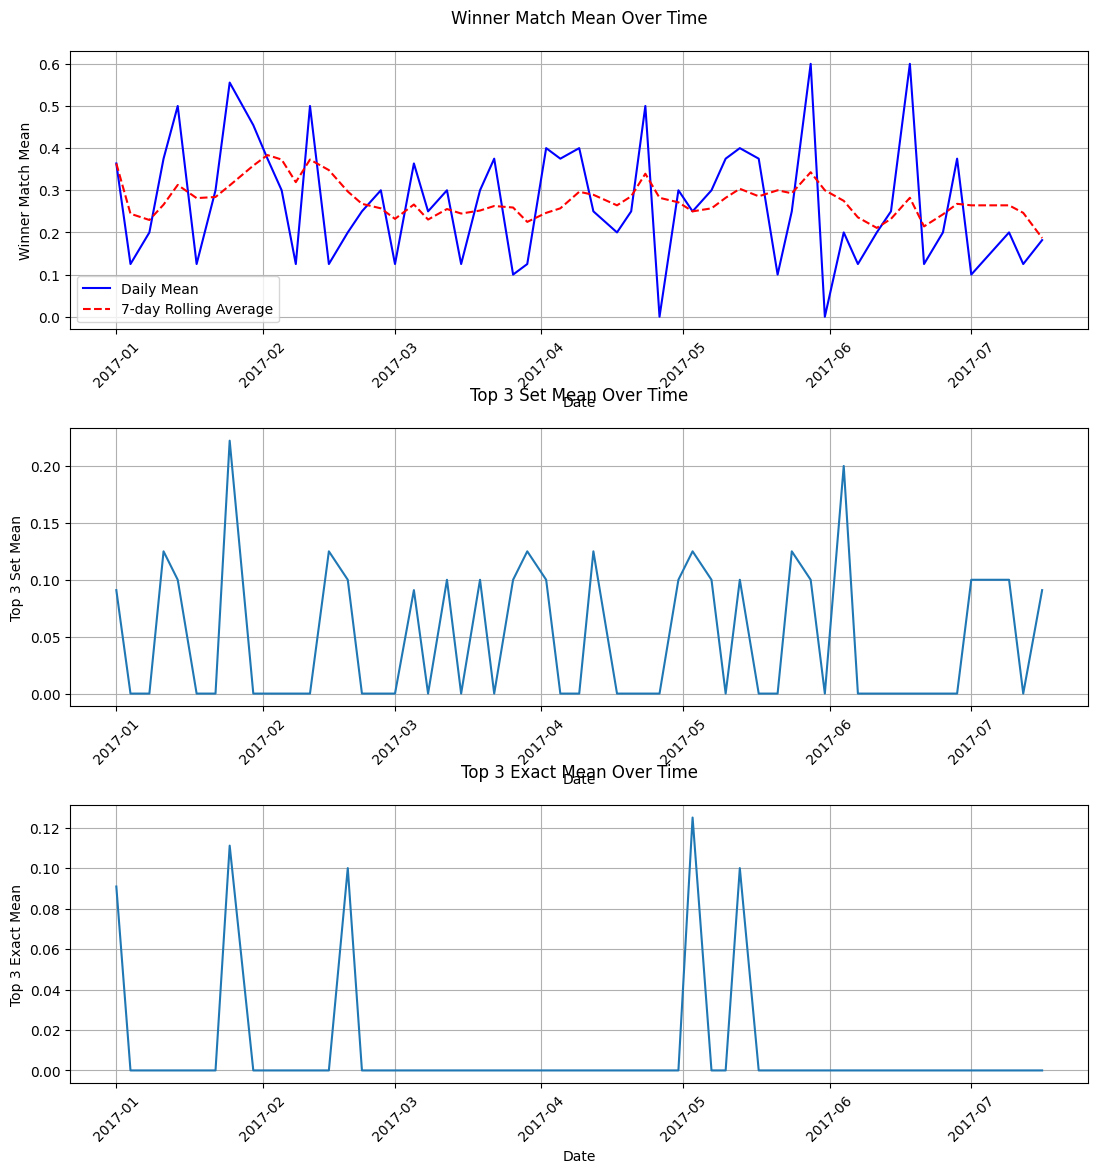

,race_date,winner_match_mean,top3set_mean,top3exact_mean
0,2017-01-01,0.36364,0.09091,0.09091
1,2017-01-04,0.12500,0.00000,0.00000
2,2017-01-08,0.20000,0.00000,0.00000
3,2017-01-11,0.37500,0.12500,0.00000
4,2017-01-14,0.50000,0.10000,0.00000
5,2017-01-18,0.12500,0.00000,0.00000
6,2017-01-22,0.30000,0.00000,0.00000
7,2017-01-25,0.55556,0.22222,0.11111
8,2017-01-30,0.45455,0.00000,0.00000
9,2017-02-02,0.37500,0.00000,0.00000


In [131]:
cols = ['race_date', 'winner_match_mean', 'top3set_mean', 'top3exact_mean']
daily_eval.columns = cols

convert_race_dates_and_plot_metrics3(daily_eval)